# MONET2030 - Data Scraping/ETL

In [1]:
# Stdlib imports
import re
from pathlib import Path
from collections import namedtuple

# 3rd party imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Local imports
from pymonet import monet_scraper as scraper
from pymonet import monet_processor as processor
from pymonet import monet_consts as const
from sipi_da_utils import utils, plot

## 1) List of all MONET2030 indicators

First, let's scrape a list of all indicators and their meta information (e.g. the URLs pointing to the indicator-specific subpages). Let's write this info to a dataframe and store it to disk.

In [2]:
itl = scraper.IndicatorTableLoader(const.url_all_monet2030_indicators, 
                                   const.indicator_table_path
                                  )
await itl.get_table()

Reading from disk...
-> done!


In [3]:
itl.table.head()

,id,sdg,topic,indicator,hyperlink,agenda2030_relevant
0,monet-1.1,1,No poverty,Poverty rate,https://www.bfs.admin.ch/bfs/en/home/statistik...,1
1,monet-1.2,1,No poverty,Total social security expenditure,https://www.bfs.admin.ch/bfs/en/home/statistik...,1
2,monet-1.3,1,No poverty,Fatalities caused by natural events,https://www.bfs.admin.ch/bfs/en/home/statistik...,1
3,monet-2.1,2,Zero hunger,Fruit and vegetables consumption,https://www.bfs.admin.ch/bfs/en/home/statistik...,1
4,monet-2.2,2,Zero hunger,Nitrogen balance from agriculture,https://www.bfs.admin.ch/bfs/en/home/statistik...,1


In [4]:
len(itl.table)

109

### Adding capitals information

**Important remark:** The capitals mapping file (corresponding to const.capmap_path) is a manually created file. If it does no longer contain the same ids as itl.table, it has to be recreated manually.

In [5]:
capmap = pd.read_csv(const.capmap_path).drop("Unnamed: 0", axis=1)
capmap.head()

,id,Capital - Primary,Capital - Secondary
0,monet-1.1,Social,Economic
1,monet-1.2,Social,Economic
2,monet-1.3,Human,Natural
3,monet-2.1,Human,NaN
4,monet-2.2,Natural,NaN


In [6]:
print(len(itl.table), len(capmap))
itl.table = itl.table.merge(capmap, on="id", how="outer")
print(len(itl.table))

109 109
109


In [7]:
itl.table.head()

,id,sdg,topic,indicator,hyperlink,agenda2030_relevant,Capital - Primary,Capital - Secondary
0,monet-1.1,1,No poverty,Poverty rate,https://www.bfs.admin.ch/bfs/en/home/statistik...,1,Social,Economic
1,monet-1.2,1,No poverty,Total social security expenditure,https://www.bfs.admin.ch/bfs/en/home/statistik...,1,Social,Economic
2,monet-1.3,1,No poverty,Fatalities caused by natural events,https://www.bfs.admin.ch/bfs/en/home/statistik...,1,Human,Natural
3,monet-10.1,10,Reduced inequalities,Distribution of equivalised primary income (S8...,https://www.bfs.admin.ch/bfs/en/home/statistik...,1,Economic,Social
4,monet-10.10,10,Reduced inequalities,Disparities in fiscal capacities of the cantons,https://www.bfs.admin.ch/bfs/en/home/statistik...,0,Economic,Social


## 2) List of all data files for all MONET2030 indicators

Given a list of all subpages related to the MONET2030 indicators (see Step 1), we can now go a step further and scrape each of these subpages. Doing so we can find yet a new set of URLs that point to the actual indicator-specific data files. It is the data in these files we are ultimately interested in.

In [8]:
mitl = scraper.MetaInfoTableLoader(itl.table,
                                   const.metainfo_table_path
                                  )
await mitl.get_table()

Reading from disk...
-> done!


In [9]:
mitl.table.head()

,dam_id,indicator_id,sdg,topic,indicator,observable,description,units,data_file_url
0,33188530,monet-1.1,1,No poverty,Poverty rate,Poverty rate,Share of people affected by income poverty in ...,In percent,https://dam-api.bfs.admin.ch/hub/api/dam/asset...
1,33188571,monet-1.1,1,No poverty,Poverty rate,Poverty rate by sex,Share of people affected by income poverty in ...,In percent,https://dam-api.bfs.admin.ch/hub/api/dam/asset...
2,33188575,monet-1.2,1,No poverty,Total social security expenditure,Total social security expenditure,As a percentage of gross domestic product,NaN,https://dam-api.bfs.admin.ch/hub/api/dam/asset...
3,33188574,monet-1.3,1,No poverty,Fatalities caused by natural events,Fatalities caused by natural events,"Floods, debris flows, landslides, rockfall, ro...",NaN,https://dam-api.bfs.admin.ch/hub/api/dam/asset...
4,28325312,monet-2.1,2,Zero hunger,Fruit and vegetables consumption,Fruit and vegetable consumption,Percentage of the population that eats at leas...,In percent,https://dam-api.bfs.admin.ch/hub/api/dam/asset...


## 3) Download all the data files

In [10]:
dfl = scraper.DataFileLoader(mitl.table, const.raw_dir)

In [11]:
dfl.get_data()

paths_exist: True
dirs_not_empty: True
Reading raw data from disk...
-> done!


## 4) Process/Transform Data

In [12]:
pipeline = processor.TransformationPipeline(dfl.raw_data_list, itl.table, mitl.table)
final_output = pipeline.run()

> Stage 1:
-> done!
> Stage 2:
-> done!
> Stage 3:
-> done!
> Stage 4:
-> done!
> Stage 5:
-> done!
> Stage 6:
-> done!
> Stage 7:
-> done!


## 5) Analysis

### 5.1) Analysis of raw data availability

In [14]:
pipeline.stages[1].additional_results['metric_id2name_map']

,metric_id,metric_name,metric_description
0,05626316a_metr,Structure of watercourses [In percent],Share of the total length of watercourses in a...
1,14711940a_metr,Nitrogen load exported [Thousand tonnes],Total nitrogen load on the Rhine at Basel
2,19804061a_metr,Time spent on professional activity and on dom...,Permanent resident population between 15 and 6...
3,19804061b_metr,Time spent on professional activity and on dom...,Permanent resident population between 15 and 6...
4,19804061c_metr,Time spent on professional activity and on dom...,Permanent resident population between 15 and 6...
...,...,...,...
230,33707241a_metr,Official development assistance for poor count...,Net official development assistance for the le...
231,33707241b_metr,Official development assistance for poor count...,Net official development assistance for the le...
232,33707243a_metr,Official Development Assistance [In percent],In proportion to gross national income (GNI)
233,33707244a_metr,Independent use of public transport by people ...,Percentage of people with severe disabilities ...


In [26]:
monet_clean = pipeline.stages[3].output
monet_clean.head()

,33188530a_metr,33188571a_metr,33188571b_metr,33188575a_metr,33188574a_metr,33188590a_metr,33188583a_metr,33188593a_metr,33188593b_metr,33188593c_metr,...,23567403a_metr,33188909a_metr,33188910a_metr,33188914a_metr,33188914b_metr,33188932a_metr,33188931a_metr,33707243a_metr,33188938a_metr,33188938b_metr
year,,,,,,,,,,,,,,,,,,,,,
1946,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1947,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1948,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


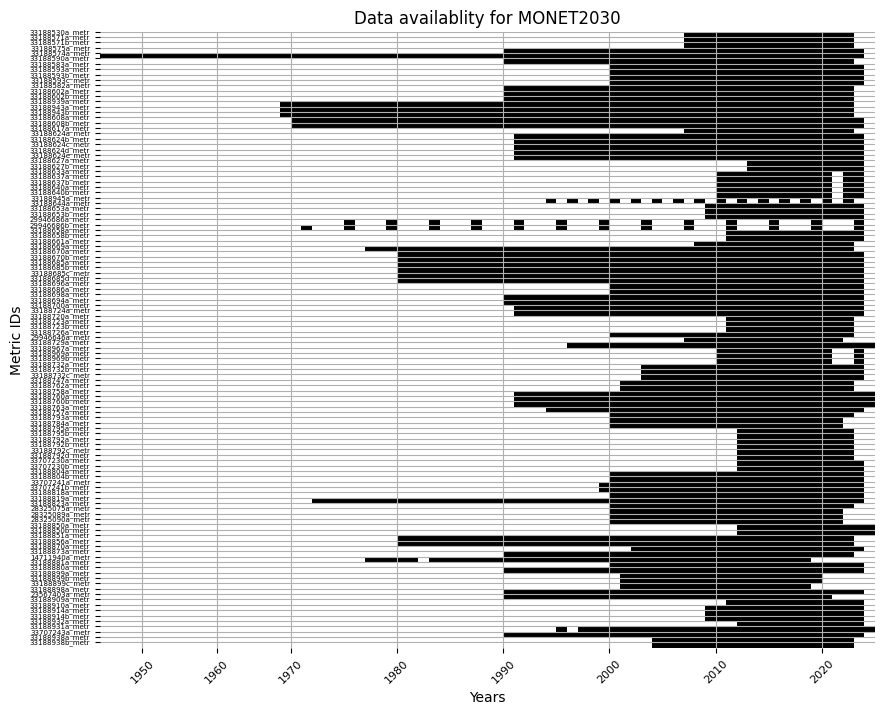

In [19]:
fig, ax = plot.visualize_data_availability(monet_clean.transpose(), 
                                      title = "Data availablity for MONET2030",
                                      x_label = "Years",
                                      y_label = "Metric IDs"
                                     )

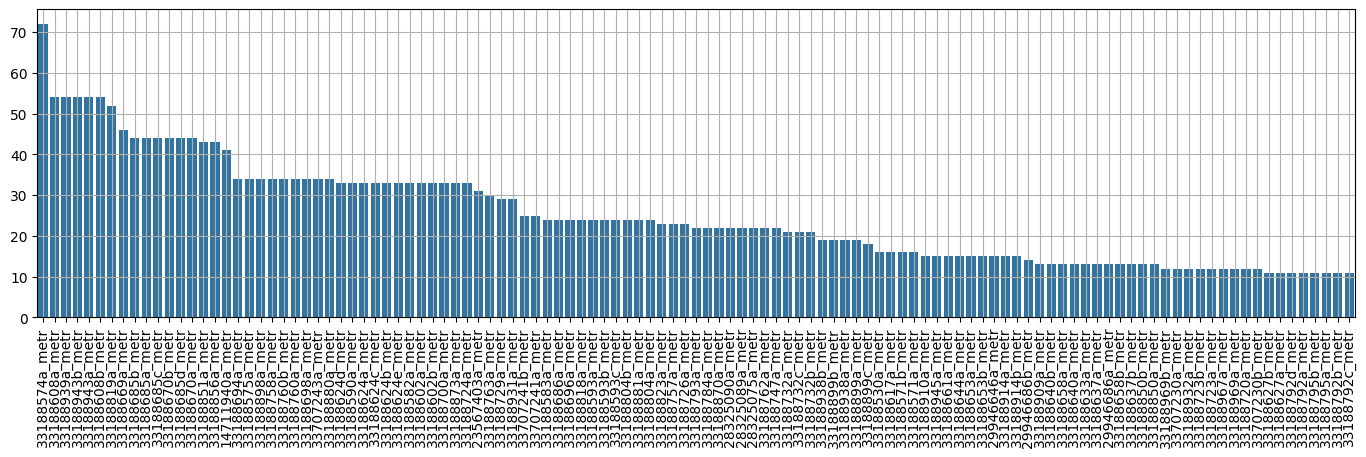

In [25]:
fig, ax = plt.subplots(figsize=(17,4))
sns.barplot(monet_clean.count().sort_values(ascending=False), ax=ax)
ax.grid(True)
plt.xticks(rotation=90)
plt.show()

## 6) Visual inspection

In [ ]:
monet_clean = pipeline.stages[3].output
monet_interp = pipeline.stages[4].output
monet_envlp = pipeline.stages[4].additional_results["uncertainty_envelopes"]

In [ ]:
fig, ax = plot.visualize_data_availability(monet_clean.transpose(), 
                                      title = "Data availablity for MONET2030",
                                      x_label = "Years",
                                      y_label = "Metric IDs"
                                     )

In [ ]:
fig, ax = plot.visualize_data_availability(monet_interp.transpose(), 
                                           title = "Data availablity for MONET2030 (after interpolation)",
                                           x_label = "Years",
                                           y_label = "Metric IDs"
                                          )

In [ ]:
rel_dam_ids = list(set([c[:8] for c in monet_clean.columns]))
len(rel_dam_ids)

fig, axs = plt.subplots(10,8, figsize=(14,20))

for i, damid in enumerate(sorted(rel_dam_ids)):
    ax = axs[i//8,i%8]
    damid_data = monet_clean.loc[:,monet_clean.columns.str.contains(str(damid))]
    damid_data.dropna().plot(ax=ax, legend=False)
    ax.grid(True)
    ax.set_title(damid)

axs[-1,-2].axis("off")
axs[-1,-1].axis("off")
plt.tight_layout()
plt.show()

In [ ]:
assert all(monet_clean.columns == monet_interp.columns)
assert all(monet_interp.columns == monet_envlp.columns)
columns = monet_clean.columns

fig, axs = plt.subplots(23,5, figsize=(25,60))

i = 0
for metric in columns:
    Data = namedtuple("Measurement", ['xvec', 'yvec'])
    data = Data(xvec = monet_clean[metric].dropna().index, 
                yvec = monet_clean[metric].dropna()
               )

    Mean = namedtuple("GP_Interpolation", ['xvec', 'yvec', 'err'])
    mean = Mean(xvec = monet_interp.index, 
                yvec = monet_interp[metric], 
                err=monet_envlp[metric]
               )
    
    ax = axs[i//5,i%5]
    ax.scatter(data.xvec, data.yvec, c="k", marker='o', label="measurements")
    ax.plot(mean.xvec, mean.yvec, c="r", label="GP")
    ax.fill_between(
            mean.xvec,
            mean.yvec - 1.96 * mean.err,
            mean.yvec + 1.96 * mean.err,
            alpha=0.3,
            color='blue',
            label="95% confidence interval")
    
    ax.grid(True)
    ax.set_title(metric)
    #ax.set_xlim([min(data.xvec)-1, max(data.xvec)+2])
    i += 1
   
plt.tight_layout()
plt.show()

## 6) Time Series Stationarity

### 6.1) Convert time information to correct data type

In [ ]:
monet_clean_ts = monet_clean.copy()
dts_index = utils.fractional_years_to_datetime(monet_clean_ts.index)
monet_clean_ts.index = dts_index
monet_clean_ts.head()

In [ ]:
dts_index = utils.fractional_years_to_datetime(monet_interp.index)
monet_interp.index = dts_index
monet_interp.head()

### 6.2) Decompose time series

In [ ]:
tsa = utils.TSAnalyzer(monet_interp, dirpath=const.tsa_dir)

In [ ]:
tsa.get_decomposition()

In [ ]:
assert all(monet_clean.columns == monet_interp.columns)
assert all(monet_interp.columns == monet_envlp.columns)
columns = monet_clean.columns

fig, axs = plt.subplots(23,5, figsize=(25,60))

i = 0
for metric in columns:
    Mean = namedtuple("GP_Interpolation", ['xvec', 'yvec', 'err'])
    mean = Mean(xvec = monet_interp[metric].dropna().index, 
                yvec = monet_interp[metric].dropna(), 
                err = monet_envlp[metric]
               )

    Trend = namedtuple("Trend", ['xvec', 'yvec'])
    trend = Trend(xvec = tsa.trend.index, 
                 yvec = tsa.trend[metric], 
                )
    
    ax = axs[i//5,i%5]
    ax.plot(trend.xvec, trend.yvec, c="gray", ls="--", label="trend")
    ax.plot(mean.xvec, mean.yvec, c="r", label="GP")
    
    
    ax.grid(True)
    ax.set_title(metric)
    #ax.set_xlim([min(mean.xvec)-1, max(mean.xvec)+2])
    i += 1
   
plt.tight_layout()
plt.show()

In [ ]:
assert all(monet_clean.columns == monet_interp.columns)
assert all(monet_interp.columns == monet_envlp.columns)
columns = monet_clean.columns

fig, axs = plt.subplots(23,5, figsize=(25,60))

i = 0
for metric in columns:
    Resid = namedtuple("Residual", ['xvec', 'yvec'])
    resid = Resid(xvec = tsa.residuals[metric].dropna().index, 
                  yvec = tsa.residuals[metric].dropna(), 
                 )
    
    ax = axs[i//5,i%5]
    ax.plot(resid.xvec, resid.yvec, c="red", label="residuals")
    ax.scatter(monet_clean_ts.loc[:,metric].dropna().index,
               monet_clean_ts.loc[:,metric].dropna()-tsa.trend.loc[monet_clean_ts.loc[:,metric].dropna().index,metric],
               marker='o',
               c="k")
    ax.axhline(y=0, c="grey", ls="--")
    ax.grid(True)
    ax.set_title(metric)
    #ax.set_xlim([min(resid.xvec)-1, max(resid.xvec)+2])
    i += 1
   
plt.tight_layout()
plt.show()

## 7) Correlation analysis

In [ ]:
monet_ca = utils.CorrelationAnalysis(monet_stat, timeseries=True)
monet_ca.compute_correlation()
#monet_ca.plot_corr_heatmap(title="Correlation Analysis of MONET2030 indicators", fpath=const.all_corrmat_file )

In [ ]:
sns.heatmap(monet_ca.corrmat)

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
ax = axs[0]
sns.histplot(monet_ca.corrmat.unstack().values, ax=ax, kde=True, bins=40)
ax.set_title("Distribution of correlation values")
ax.set_xlabel("corr")

ax = axs[1]
sns.histplot(monet_ca.corrmat.unstack().abs().values, ax=ax, bins=20)
ax.set_title("Distribution of abs(correlation) values")
ax.set_xlabel("abs(corr)")
plt.tight_layout()
plt.show()

### 7.1) Removing strongly correlated metrics in a greedy approach

In [ ]:
non_redundant_metrics, found_correlations = monet_ca.drop_strong_correlations(threshold=0.9, 
                                                                              fpath_corr = const.pruned_metrics_file
                                                                             )
len(non_redundant_metrics)

In [ ]:
fig, ax = plt.subplots(figsize=(10,9))
sns.heatmap(monet_ca.corrmat.loc[non_redundant_metrics,non_redundant_metrics], vmin=-1, vmax=1, ax=ax)
ax.set_title("Correlation Analysis of MONET2030 indicators (pruned)")
plt.tight_layout()
fig.savefig(const.pruned_corrmat_file)
plt.show()

In [ ]:
# Map non-redundant metrics to non-redundant observables/dam_ids
non_redundant_dam_ids = set([int(mtr.split("_")[0][:-1]) for mtr in non_redundant_metrics])
print(len(non_redundant_dam_ids))
non_redundant_observables_df=mitl.table[mitl.table["dam_id"].isin(non_redundant_dam_ids)]
non_redundant_observables_df.head(3)

In [ ]:
non_redundant_observables_df.to_csv(const.non_redundant_obs_file, index=False)

In [ ]:
# Map non-redundant damids to non-redundant indicators
non_redundant_indicators = non_redundant_observables_df[["indicator_id", "indicator"]].drop_duplicates()
non_redundant_indicators.head()

In [ ]:
print(f"We removed {round((100*(1-len(non_redundant_indicators)/len(itl.table))),2)}% of the original indicators in total.")

In [ ]:
monet_ca.corrmat.loc["28325349a_metr", "28325338b_metr"]

In [ ]:
corrmat=monet_interp.corr()

In [ ]:
corrmat.loc["28325349a_metr", "28325338b_metr"]

In [ ]:
stds = monet_interp.diff().std()
stds.argmin()

In [ ]:
stds.iloc[139]

In [ ]:
stds.keys()[139]

In [ ]:
mitl.table[mitl.table["dam_id"]==33188879]

In [ ]:
relevant_monet_df[["28325338b_metr", "28325349a_metr"]].dropna().diff().corr()

In [ ]:
relevant_monet_df[].dropna()

In [ ]:
mitl.table[mitl.table["dam_id"].duplicated(keep=False)].sort_values(by="dam_id")